[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sensioai/blog/blob/master/033_receta_entrenamiento/receta_entrenamiento.ipynb)

# Receta para entrenar Redes Neuronales

En posts anteriores hemos introducido muchos conceptos que nos pueden ayudar a la hora de entrenar redes neuronales de manera efectiva, consiguiendo buenas prestaciones. En este post vamos a presentar una receta sencilla que puedes seguir para empezar a entrenar tus redes aplicando las prácticas más comunes con el objetivo de minimizar la posibilidad de introducir errores en el proceso.

## Exploración de Datos 

Cualquier proyecto de `Machine Learning` empieza siempre con una fase de exploración de datos. Estas son algunas de las preguntas que deberías responder antes de ponerte a entrenar ningún modelo:

- Tipo de problema: regresión, clasificación (binaria, multiclase, ...), ...
- Número de clases (clasificación) o valores a predecir (regresión)
- Distribución de clases

En este ejemplo seguiremos trabajando con el dataset CIFAR10 para clasificación de imágenes, por lo que también nos interesa: 

- Visualizar imágenes
- Número de canales (gris, color, multi-espectral, ...)
- Resolución (alto y ancho)
- Estadísticos (mean/std, max/min, ...)
- Tipo de datos (unit8, float16, ...)

Y cualquier otro aspecto que sea relevante.

In [1]:
import torchvision

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

len(trainset), len(testset)

100%|██████████| 170498071/170498071 [00:17<00:00, 9662316.77it/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


(50000, 10000)

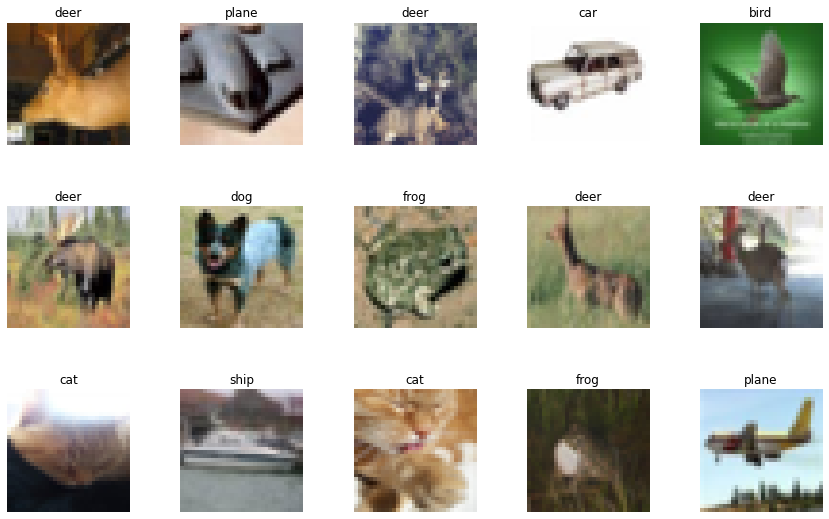

In [2]:
# visualizción imágenes 

import random 
import matplotlib.pyplot as plt

r, c = 3, 5
plt.figure(figsize=(c*3, r*3))
for row in range(r):
    for col in range(c):
        index = c*row + col
        plt.subplot(r, c, index + 1)
        ix = random.randint(0, len(trainset)-1)
        img, label = trainset[ix]
        plt.imshow(img)
        plt.axis('off')
        plt.title(classes[label])
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

In [3]:
# convertimos imágenes a arrays de numpy

import numpy as np

train_images = np.array([np.array(img) for img, label in trainset])
test_images = np.array([np.array(img) for img, label in testset])

train_labels = np.array([label for img, label in trainset])
test_labels = np.array([label for img, label in testset])

In [4]:
# ver número de imágenes, resolución y número de canales

train_images.shape, test_images.shape, train_labels.shape, test_labels.shape

((50000, 32, 32, 3), (10000, 32, 32, 3), (50000,), (10000,))

In [5]:
# tipo de datos

train_images.dtype, train_labels.dtype

(dtype('uint8'), dtype('int64'))

In [6]:
# estadísiticos

max_value = train_images.max(axis=(0, 1, 2))
min_value = train_images.min(axis=(0, 1, 2))

max_value, min_value

(array([255, 255, 255], dtype=uint8), array([0, 0, 0], dtype=uint8))

In [7]:
mean = (train_images / 255).mean(axis=(0, 1, 2))
std = (train_images / 255).std(axis=(0, 1, 2))

mean, std

(array([0.49139968, 0.48215841, 0.44653091]),
 array([0.24703223, 0.24348513, 0.26158784]))

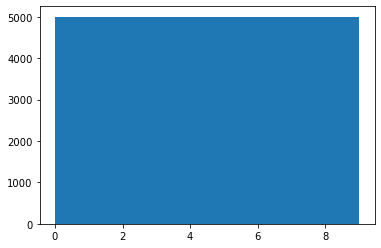

In [8]:
# distribución de clases

plt.hist(train_labels, bins=len(classes))
plt.show()

In [9]:
unique, counts = np.unique(train_labels, return_counts=True)
unique, counts

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000]))

En este caso nuestro dataset está balanceado (tenemos el mismo número de muestras por cada clase). En ocasiones, éste no será el caso. Entrenar un modelo con un dataset desbalanceado introducirá *bias*, haciendo que nuestro modelo sea más propenso a predecir las clases más presentes. Para solventar este problema existen varias opciones, la más común es sobre-muestrear las clases menos representadas (combinado con *data augmentation* puede ser especialmente positivo).

Una vez conocemos bien nuestros datos, podemos empezar a trabajar en nuestra `red neuronal`. Sin embargo, antes de entrenarla en todo nuestro dataset será muy positivo seguir antes los siguiente pasos.

## Validando nuestra red neuronal

Digamos que decidimos usar una arquitectura de `MLP` para resolver nuestro problema. 

In [10]:
import torch

def build_model(D_in=32*32*3, H=100, D_out=10):
    return torch.nn.Sequential(
        torch.nn.Linear(D_in, H),
        torch.nn.ReLU(),
        torch.nn.Linear(H, H),
        torch.nn.ReLU(),
        torch.nn.Linear(H, D_out)
    ).cuda()

Una muy buena manera de asegurarnos que nuestra red hace lo que debería es pasarle como entrada un `tensor` con las dimensiones esperadas durante el entrenamiento y asegurarnos que la salida que nos da coincide también con lo que esperamos. En nuestro caso, enviaremos tensores que contendrán un número determinado de imágenes (un *batch*, por ejemplo 64) y cada imagen estará representada por un vector de $32*32*3$ valores. La salida debería ser un vector de 10 valores para cada imagen del *batch* representando la probabilidad de cada clase.

In [11]:
model = build_model()
test_input = torch.randn((64, 32*32*3)).cuda()
test_output = model(test_input)
test_output.shape

torch.Size([64, 10])

Si cometemos algún error definiendo nuestra red neuronal, en este paso lo podríamos detectar (en esta caso el `MLP` es una arquitectura muy sencilla, pero con redes neuronales grandes es muy fácil cometer errores a la hora de definir las dimensiones de cada capa).

### Fit de una muestra

Una vez nos hemos asegurado que las dimensiones de nuestra red están bien, el siguiente paso es asegurarnos de que es capaz de aprenderse de memoria una sola muestra del dataset. Si este no es el caso podemos estar seguros de que algo no anda bien.

In [12]:
import numpy as np

train_images = np.array([np.array(img) for img, label in trainset])
X_test = np.array([np.array(img) for img, label in testset])

train_labels = np.array([label for img, label in trainset])
y_test = np.array([label for img, label in testset])

X_train, X_val, X_subset = train_images[:40000], train_images[40000:], train_images[:5000]
y_train, y_val, y_subset = train_labels[:40000], train_labels[40000:], train_labels[:5000]

X_train.shape, X_val.shape, X_test.shape, X_subset.shape

((40000, 32, 32, 3), (10000, 32, 32, 3), (10000, 32, 32, 3), (5000, 32, 32, 3))

In [13]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, X, Y):
        self.X = torch.from_numpy(X / 255.).float().cuda().view(-1, 32*32*3)
        self.Y = torch.from_numpy(Y).long().cuda()
    def __len__(self):
        return len(self.X)
    def __getitem__(self, ix):
        return self.X[ix], self.Y[ix]

In [14]:
# fit de la primera imagen del dataset 

dataset = Dataset(X_subset[:1], y_subset[:1])
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1)

len(dataset)

1

In [15]:
epochs = 3
criterion = torch.nn.CrossEntropyLoss()
model = build_model()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
for e in range(1, epochs+1): 
    for x_b, y_b in dataloader:
        y_pred = model(x_b)
        loss = criterion(y_pred, y_b)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print(f"Epoch {e}/{epochs} loss {loss.item():.5f} y {y_b.item()} y_pred {torch.argmax(y_pred, axis=1).item()}")

Epoch 1/3 loss 2.32061 y 6 y_pred 0
Epoch 2/3 loss 0.00003 y 6 y_pred 6
Epoch 3/3 loss 0.00000 y 6 y_pred 6


Podemos hacer el fit de una imagen sin problema. Errores como una función de pérdida incorrecta o diferentes dimensiones entre las predicciones y las etiquetas podrían ser detectados en este paso. 

### Fit de un *batch*

Siguiendo la misma lógica, nuestro modelo debería ser capaz de aprenderse de memoria un solo *batch* de imágenes.

In [16]:
# fit de un batch

dataset = Dataset(X_subset[:64], y_subset[:64])
dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)

len(dataset)

64

In [17]:
epochs = 100
criterion = torch.nn.CrossEntropyLoss()
model = build_model()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
for e in range(1, epochs+1): 
    for x_b, y_b in dataloader:
        y_pred = model(x_b)
        loss = criterion(y_pred, y_b)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        acc = (y_b == torch.argmax(y_pred, axis=1)).sum().item()  
        if not e % 10:
            print(f"Epoch {e}/{epochs} loss {loss.item():.5f} acc {acc}/{y_b.shape[0]}")

Epoch 10/100 loss 2.23111 acc 8/64
Epoch 20/100 loss 2.00015 acc 17/64
Epoch 30/100 loss 1.50520 acc 29/64
Epoch 40/100 loss 0.87922 acc 49/64
Epoch 50/100 loss 0.44099 acc 54/64
Epoch 60/100 loss 0.17266 acc 63/64
Epoch 70/100 loss 0.05964 acc 64/64
Epoch 80/100 loss 0.02262 acc 64/64
Epoch 90/100 loss 0.00965 acc 64/64
Epoch 100/100 loss 0.00535 acc 64/64


En este punto ya podemos estar bastante seguros de que nuestro modelo está bien definido, estamos usando la función de pérdida y optimizador adecuados, nuestro bucle de entrenamiento funciona bien, etc. 

## Entrenando con un sub-conjunto de datos

Entrenar una `red neuronal` en un dataset completo puede ser computacionalmente costoso si el dataset es muy grande. Esto implica que si queremos hacer pruebas para probar diferentes combinaciones de hyperparámetros vamos a tener que esperar mucho tiempo, o alquilar grandes *clusters* de GPUs (lo cual es muy caro). Una solución es iterar utilizando un sub-conjunto representativo de nuestro dataset, confiando en que las conclusiones a las que lleguemos en este pequeño conjunto luego se transfieran a todo el dataset. 

In [18]:
dataset = {
    'train': Dataset(X_subset, y_subset),
    'val': Dataset(X_val, y_val),
}

dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=32, shuffle=True),
    'val': torch.utils.data.DataLoader(dataset['val'], batch_size=1000, shuffle=False)
}

len(dataset['train']), len(dataset['val'])

(5000, 10000)

In [19]:
from sklearn.metrics import accuracy_score

def softmax(x):
    return torch.exp(x) / torch.exp(x).sum(axis=-1,keepdims=True)

def fit(model, dataloader, optimizer, scheduler=None, epochs=10, log_each=1, weight_decay=0, early_stopping=0, verbose=1):
    criterion = torch.nn.CrossEntropyLoss()
    l, acc, lr = [], [], []
    val_l, val_acc = [], []
    best_acc, step = 0, 0
    for e in range(1, epochs+1): 
        _l, _acc = [], []
        for param_group in optimizer.param_groups:
            lr.append(param_group['lr'])
        model.train()
        for x_b, y_b in dataloader['train']:
            y_pred = model(x_b)
            loss = criterion(y_pred, y_b)
            _l.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            y_probas = torch.argmax(softmax(y_pred), axis=1)            
            _acc.append(accuracy_score(y_b.cpu().numpy(), y_probas.cpu().detach().numpy()))
        l.append(np.mean(_l))
        acc.append(np.mean(_acc))
        model.eval()
        _l, _acc = [], []
        with torch.no_grad():
            for x_b, y_b in dataloader['val']:
                y_pred = model(x_b)
                loss = criterion(y_pred, y_b)
                _l.append(loss.item())
                y_probas = torch.argmax(softmax(y_pred), axis=1)            
                _acc.append(accuracy_score(y_b.cpu().numpy(), y_probas.cpu().numpy()))
        val_l.append(np.mean(_l))
        val_acc.append(np.mean(_acc))
        # guardar mejor modelo
        if val_acc[-1] > best_acc:
            best_acc = val_acc[-1]
            torch.save(model.state_dict(), 'ckpt.pt')
            step = 0
            if verbose == 2:
                print(f"Mejor modelo guardado con acc {best_acc:.5f} en epoch {e}")
        step += 1
        if scheduler:
            scheduler.step()
        # parar
        if early_stopping and step > early_stopping:
            print(f"Entrenamiento detenido en epoch {e} por no mejorar en {early_stopping} epochs seguidas")
            break
        if not e % log_each and verbose:
            print(f"Epoch {e}/{epochs} loss {l[-1]:.5f} acc {acc[-1]:.5f} val_loss {val_l[-1]:.5f} val_acc {val_acc[-1]:.5f} lr {lr[-1]:.5f}")
    # cargar mejor modelo
    model.load_state_dict(torch.load('ckpt.pt'))
    return {'epoch': list(range(1, len(l)+1)), 'loss': l, 'acc': acc, 'val_loss': val_l, 'val_acc': val_acc, 'lr': lr}

Por ejemplo, de la siguiente manera podríamos elegir un *learning rate* adecuado.

In [20]:
lrs = [0.01, 0.001, 0.0001]
hists = []
for lr in lrs:
    print(f"Probando lr {lr}")
    model = build_model()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    hist = fit(model, dataloader, optimizer, epochs=10, verbose=0)
    hists.append(hist)
    
# tarda 12 segundos

Probando lr 0.01
Probando lr 0.001
Probando lr 0.0001


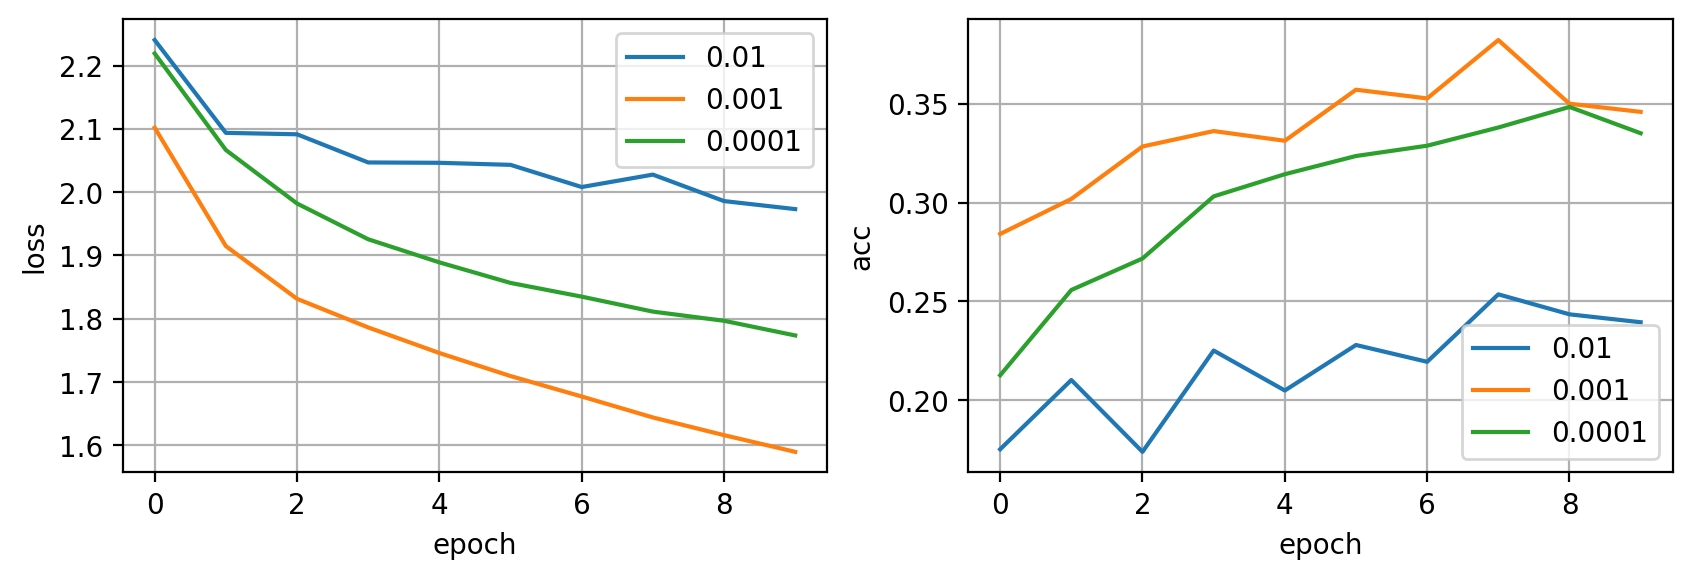

In [21]:
fig = plt.figure(dpi=200, figsize=(10,3))
ax = plt.subplot(121)
for i in range(len(lrs)):
    ax.plot(hists[i]['loss'], label=lrs[i])
ax.legend()
ax.grid(True)
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax = plt.subplot(122)
for i in range(len(lrs)):
    ax.plot(hists[i]['val_acc'], label=lrs[i])
ax.legend()
ax.grid(True)
ax.set_ylabel('acc')
ax.set_xlabel('epoch')
plt.show()

Parece que el valor intermedio de 0.001 nos da los mejores resultados en este caso. Ahora repetimos el experimento con todos los datos.

In [22]:
dataset = {
    'train': Dataset(X_train, y_train),
    'val': Dataset(X_val, y_val),
}

dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=32, shuffle=True),
    'val': torch.utils.data.DataLoader(dataset['val'], batch_size=1000, shuffle=False)
}

len(dataset['train']), len(dataset['val'])

(40000, 10000)

In [23]:
hists = []
for lr in lrs:
    print(f"Probando lr {lr}")
    model = build_model()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    hist = fit(model, dataloader, optimizer, epochs=10, verbose=0)
    hists.append(hist)
    
# tarda 1 minuto y 17 segundos

Probando lr 0.01
Probando lr 0.001
Probando lr 0.0001


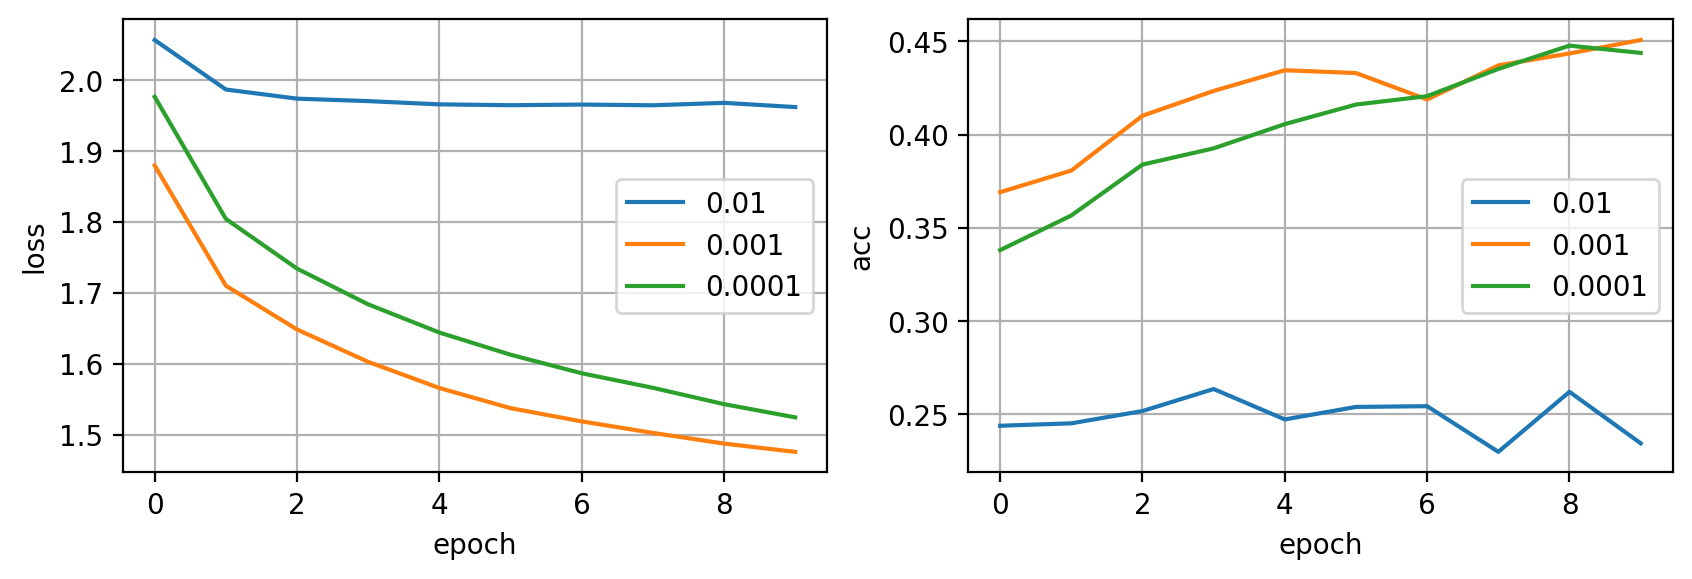

In [24]:
fig = plt.figure(dpi=200, figsize=(10,3))
ax = plt.subplot(121)
for i in range(len(lrs)):
    ax.plot(hists[i]['loss'], label=lrs[i])
ax.legend()
ax.grid(True)
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax = plt.subplot(122)
for i in range(len(lrs)):
    ax.plot(hists[i]['val_acc'], label=lrs[i])
ax.legend()
ax.grid(True)
ax.set_ylabel('acc')
ax.set_xlabel('epoch')
plt.show()

Obtenemos el mismo resultado, pero necesitando mucho más tiempo y cálculo. Así pues, experimentar rápidamente en un subconjunto representativo nos puede dar una gran ventaja.

## Configuraciones recomendadas

Es fácil verse sobrepasado por el gran número de opciones que tenemos disponibles a la hora de entrenar nuestras redes, y obviamente no podemos probar todas las posibles combinaciones. Lo que podemos hacer es basarnos en el trabajo llevado a cabo por otros y utilizar sus resultados para empezar a trabajar. Estos son algunos buenos valores iniciales que puedes usar.

### Batch Size

Valores recomendados son: 16, 32, 64. Puedes empezar por estos valores y luego experimentar con otros. Aún así, la tendencia es intentar utilizar el *batch size* más grande posible que quepa en la memoria de la GPU (o GPUs) y adaptar el *learning rate* para obtener un buen entrenamiento.

In [25]:
bss = [16, 32, 64]
hists = []
for bs in bss:
    print(f"Probando bs {bs}")
    dataloader = {
        'train': torch.utils.data.DataLoader(dataset['train'], batch_size=bs, shuffle=True),
        'val': torch.utils.data.DataLoader(dataset['val'], batch_size=1000, shuffle=False)
    }
    model = build_model()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    hist = fit(model, dataloader, optimizer, epochs=10, verbose=0)
    hists.append(hist)

Probando bs 16
Probando bs 32
Probando bs 64


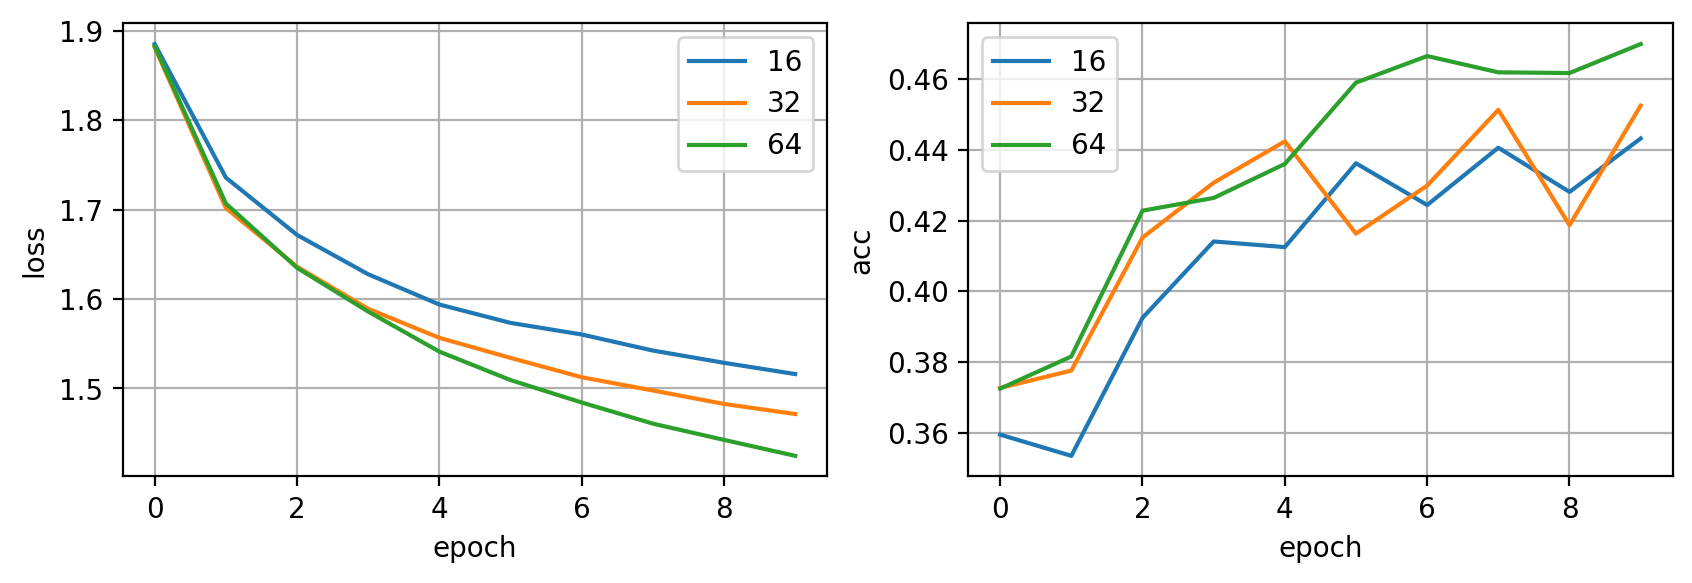

In [26]:
fig = plt.figure(dpi=200, figsize=(10,3))
ax = plt.subplot(121)
for i in range(len(bss)):
    ax.plot(hists[i]['loss'], label=bss[i])
ax.legend()
ax.grid(True)
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax = plt.subplot(122)
for i in range(len(bss)):
    ax.plot(hists[i]['val_acc'], label=bss[i])
ax.legend()
ax.grid(True)
ax.set_ylabel('acc')
ax.set_xlabel('epoch')
plt.show()

### Optimizador y *learning rate*

Un buena combinación inicial es el optimizador *Adam* con un *learning rate* de $0.001$. A partir de aquí puede experimentar con otros valores para sacar un extra de *performance*, pero estos valores suelen ser buenos para empezar.

### Regularización

Cuando trabajamos con imágenes, utilizar *data augmentation* y *batch norm* es muy aconsejable para obtener buenos resultados. Combinándolo con *early stopping* seremos capaces de maneter el *overfitting* a raya. Puedes usar *Weight decay* si utilizas el optimizador *SGD* para regularizar mnás tu modelo, e incluso probar *Dropout* (sobretodo en arquitecturas de tipo `MLP`, no tanto en redes convolucionales).

In [27]:
def build_model(D_in=32*32*3, H=100, D_out=10):
    return torch.nn.Sequential(
        torch.nn.Linear(D_in, H),
        torch.nn.BatchNorm1d(H),
        torch.nn.ReLU(),
        torch.nn.Linear(H, H),
        torch.nn.BatchNorm1d(H),
        torch.nn.ReLU(),
        torch.nn.Linear(H, D_out)
    ).cuda()

In [ ]:
!conda install -c conda-forge imgaug
!conda install -c conda-forge albumentations


Solving environment: / 

In [30]:
from albumentations import Compose, RandomCrop, Resize, HorizontalFlip, ToGray, RGBShift, OneOf

trans = Compose([
    RandomCrop(24,24),
    Resize(32, 32),
    HorizontalFlip(),
    OneOf([
        ToGray(p=0.2),
        RGBShift(p=0.3)
    ])
])

class Dataset(torch.utils.data.Dataset):
    def __init__(self, X, Y, trans=None):
        self.X = X
        self.Y = Y
        self.trans = trans
    def __len__(self):
        return len(self.X)
    def __getitem__(self, ix):
        img = self.X[ix]
        if self.trans:
            img = trans(image=img)["image"]
        img = torch.from_numpy(img / 255.).float().cuda().view(-1)
        label = torch.tensor(self.Y[ix]).long().cuda()
        return img, label

dataset = {
    'train': Dataset(X_subset, y_subset, trans=trans),
    'val': Dataset(X_val, y_val),
}

dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=64, shuffle=True),
    'val': torch.utils.data.DataLoader(dataset['val'], batch_size=1000, shuffle=False)
}

len(dataset['train']), len(dataset['val'])

TypeError: 'numpy._DTypeMeta' object is not subscriptable

In [31]:
model = build_model()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
hist = fit(model, dataloader, optimizer, epochs=100, early_stopping=10, verbose=2)

Mejor modelo guardado con acc 0.44200 en epoch 1
Epoch 1/100 loss 1.67098 acc 0.40365 val_loss 1.57946 val_acc 0.44200 lr 0.00100
Epoch 2/100 loss 1.46285 acc 0.47747 val_loss 1.54930 val_acc 0.43930 lr 0.00100
Mejor modelo guardado con acc 0.46960 en epoch 3
Epoch 3/100 loss 1.37145 acc 0.50943 val_loss 1.48825 val_acc 0.46960 lr 0.00100
Mejor modelo guardado con acc 0.49060 en epoch 4
Epoch 4/100 loss 1.30090 acc 0.53510 val_loss 1.43418 val_acc 0.49060 lr 0.00100
Mejor modelo guardado con acc 0.51040 en epoch 5
Epoch 5/100 loss 1.24874 acc 0.55588 val_loss 1.39018 val_acc 0.51040 lr 0.00100
Mejor modelo guardado con acc 0.51680 en epoch 6
Epoch 6/100 loss 1.20490 acc 0.57368 val_loss 1.37339 val_acc 0.51680 lr 0.00100
Epoch 7/100 loss 1.16091 acc 0.58480 val_loss 1.51357 val_acc 0.47480 lr 0.00100
Epoch 8/100 loss 1.12534 acc 0.59783 val_loss 1.51299 val_acc 0.47870 lr 0.00100
Epoch 9/100 loss 1.09505 acc 0.61103 val_loss 1.52345 val_acc 0.47760 lr 0.00100
Epoch 10/100 loss 1.06227 

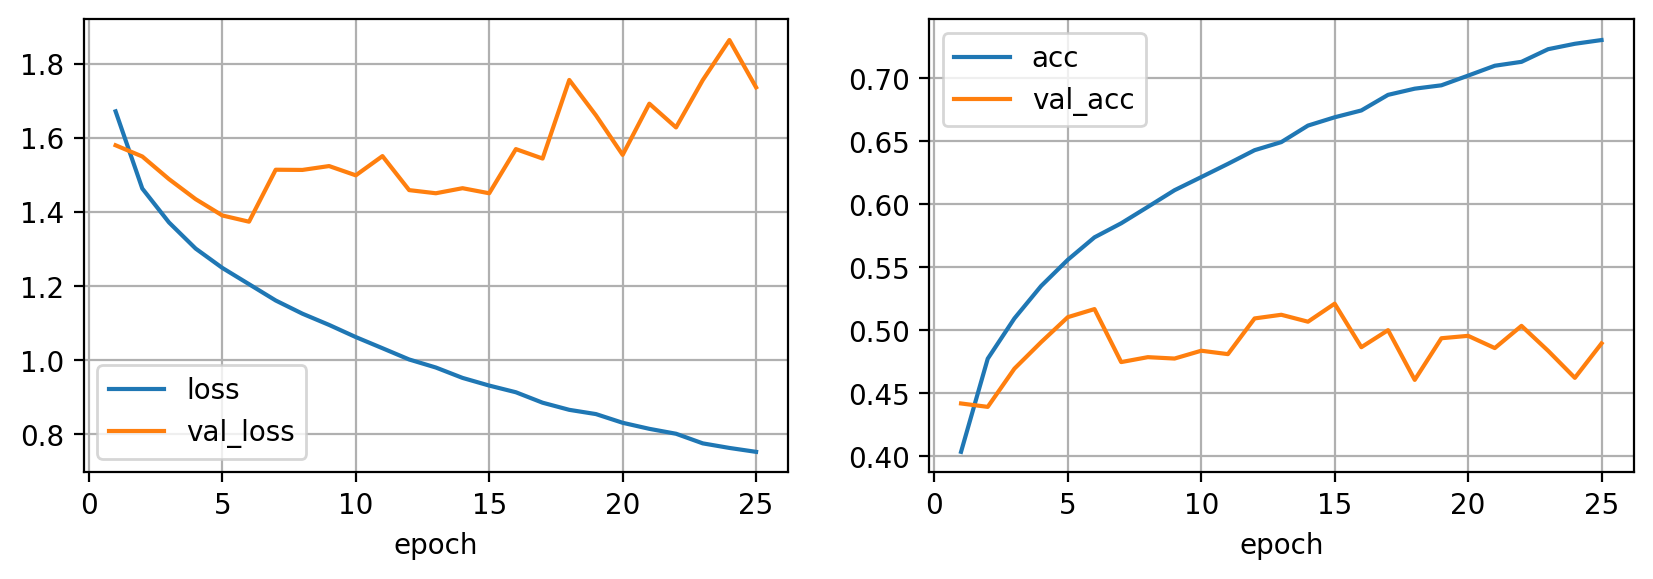

In [32]:
import pandas as pd 

fig = plt.figure(dpi=200, figsize=(10,3))
ax = plt.subplot(121)
pd.DataFrame(hist).plot(x='epoch', y=['loss', 'val_loss'], grid=True, ax=ax)
ax = plt.subplot(122)
pd.DataFrame(hist).plot(x='epoch', y=['acc', 'val_acc'], grid=True, ax=ax)
plt.show()

Puedes usar tu subset para experimentar rápidamente diferentes combinaciones de transformaciones para encontrar la mejor para tu caso en particular (aunque la opción por defecto es utilizar cuántas más, mejor).

## Tuneado de Hyperparámetros

Una vez hemos elegido unos buenos valores iniciales, tenemos que empezar a explorar el espacio de hyperparámetros de nuestro problema para escoger la mejor combinación. Para ello tenemos dos opciones: *grid search* o *random search*. En el primer caso, definiremos todas las posibles combinaciones que queremos probar y las probaremos todas. Como puedes imaginar esto puede ser muy costoso y potencialmente ineficiente. La segunda opción es más recomendada, y consiste en definir un espacio de búsqueda y ejecutar un número determinado de entrenamientos, para cada cual escogeremos un conjunto de hiperparámetros aleatorios del espacio de búsqueda. 

![](https://pvsmt99345.i.lithium.com/t5/image/serverpage/image-id/74545i97245FDAA10376E9?v=1.0)

In [33]:
# ejemplo de random search

bss = [16, 32, 64, 128, 256]
lrs = [0.01, 0.005, 0.001, 0.0003, 0.0001]
n = 5
hists = []
for i in range(n):
    lr = random.choice(lrs)
    bs = random.choice(bss)
    print(f"Test {i+1} lr {lr} bs {bs}")
    dataloader = {
        'train': torch.utils.data.DataLoader(dataset['train'], batch_size=bs, shuffle=True),
        'val': torch.utils.data.DataLoader(dataset['val'], batch_size=1000, shuffle=False)
    }
    model = build_model()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    hist = fit(model, dataloader, optimizer, epochs=20, verbose=0)
    hists.append({'hist': hist, 'lr': lr, 'bs': bs})

Test 1 lr 0.01 bs 32
Test 2 lr 0.005 bs 32
Test 3 lr 0.0001 bs 16
Test 4 lr 0.001 bs 64
Test 5 lr 0.01 bs 128


In [ ]:
fig = plt.figure(dpi=200, figsize=(10,3))
ax = plt.subplot(121)
for i in range(len(hists)):
    ax.plot(hists[i]['hist']['loss'], label=f'lr {hists[i]["lr"]} bs {hists[i]["bs"]}')
ax.legend()
ax.grid(True)
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax = plt.subplot(122)
for i in range(len(hists)):
    ax.plot(hists[i]['hist']['val_acc'], label=f'lr {hists[i]["lr"]} bs {hists[i]["bs"]}')
ax.legend()
ax.grid(True)
ax.set_ylabel('acc')
ax.set_xlabel('epoch')
plt.show()

## Últimos toques

Y ya para terminar, puedes experimentar con varios *schedulers* que vayan modificando el *learning rate* durante el entrenamiento. Esta técnica es especialmente interesante en combinación con *transfer learning*, algo de lo que hablaremos en detalle más adelante.

In [ ]:
model = build_model()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 20, 0.1)
hist = fit(model, dataloader, optimizer, scheduler, epochs=100, early_stopping=10, verbose=2)

In [ ]:
fig = plt.figure(dpi=200, figsize=(10,3))
ax = plt.subplot(131)
pd.DataFrame(hist).plot(x='epoch', y=['loss', 'val_loss'], grid=True, ax=ax)
ax = plt.subplot(132)
pd.DataFrame(hist).plot(x='epoch', y=['acc', 'val_acc'], grid=True, ax=ax)
ax = plt.subplot(133)
pd.DataFrame(hist).plot(x='epoch', y=['lr'], grid=True, ax=ax)
plt.tight_layout()
plt.show()

Y, por supuesto, utilizar todos los datos una vez hayas encontrado una buena combinación de hyperparámetros en tu subset.

In [ ]:
dataset = {
    'train': Dataset(X_train, y_train, trans=trans),
    'val': Dataset(X_val, y_val),
}

dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=64, shuffle=True),
    'val': torch.utils.data.DataLoader(dataset['val'], batch_size=1000, shuffle=False)
}

len(dataset['train']), len(dataset['val'])

In [ ]:
model = build_model()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 20, 0.1)
hist = fit(model, dataloader, optimizer, scheduler, epochs=100, early_stopping=10, verbose=2)

In [ ]:
fig = plt.figure(dpi=200, figsize=(10,3))
ax = plt.subplot(131)
pd.DataFrame(hist).plot(x='epoch', y=['loss', 'val_loss'], grid=True, ax=ax)
ax = plt.subplot(132)
pd.DataFrame(hist).plot(x='epoch', y=['acc', 'val_acc'], grid=True, ax=ax)
ax = plt.subplot(133)
pd.DataFrame(hist).plot(x='epoch', y=['lr'], grid=True, ax=ax)
plt.tight_layout()
plt.show()

## Resumen

En este post hemos presentado una "receta" para entrenar redes neuronales de manera efectiva. Siguiendo estos pasos podrás diseñar tus arquitecturas, validar que sean correctas haciendo fit primero de una sola muestra, luego de un batch y por último utilizando un pequeño conjunto de datos para encontrar de manera rápida una combinación óptima de hyperparámetros a partir de una configuración recomendad con valores iniciales que suelen funcionar bien en la práctica. A partir de aquí, podrás mejorar tu modelo con técnicas más sofisticadas que te darán un extra en la *performance* de tus modelos.